In [1]:
import tensorflow as tf
import numpy as np
import cv2

import matplotlib.pyplot as plt

from cell_division.nets.transfer_learning import CNN
from auxiliary.data.dataset_cell import CellDataset
from auxiliary import values as v
from auxiliary.utils import visualizer as vis

from sklearn.metrics import classification_report, confusion_matrix
from cell_division.layers.custom_layers import (
    ExtendedLSEPooling,
    extended_w_cel_loss
)

from cell_division.nets.cam import overlay_heatmap, CAM

# GPU config
from auxiliary.gpu.gpu_tf import (
    increase_gpu_memory, 
    set_gpu_allocator
)
plt.style.use('default')

increase_gpu_memory()
set_gpu_allocator()


Data

In [2]:
img_dir = v.data_path + 'CellDivision/images_nuclei/'
label_train_dir = v.data_path + 'CellDivision/undersampled/train.csv'
label_test_dir = v.data_path + 'CellDivision/undersampled/test.csv'
label_val_dir = v.data_path + 'CellDivision/undersampled/val.csv'

INPUT_SHAPE = (100, 100, 3)
BATCH_SIZE = 32

In [3]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

test_generator = CellDataset(
    img_dir, 
    label_test_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

Training

In [4]:
model = CNN(
    base=tf.keras.applications.VGG16,
    input_shape=INPUT_SHAPE,
    n_classes=3
)
model.build_top(activation='softmax', b_type='CAM', pooling=ExtendedLSEPooling)
model.compile(
    lr=.001,
    loss=extended_w_cel_loss()
)

In [5]:
# model.fit(
#     train_generator,
#     val_generator,
#     epochs=100,
#     verbose=2,
#     batch_size=BATCH_SIZE
# )
# 
# model.model.save('../models/cellular_division_models/vgg16_nuclei_under.h5')

In [6]:
model.load('../models/cellular_division_models/vgg16_nuclei_under.h5')

Testing

In [7]:
results = model.model.evaluate(test_generator, verbose=1)

4/4 [==============================] - 5s 734ms/step - loss: 0.6904 - auc: 0.9435


In [ ]:
pred = model.model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

In [ ]:
cf_matrix = confusion_matrix(
    test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

Grad-CAM

In [ ]:
test_generator = CellDataset(
    img_dir, 
    label_test_dir, 
    batch_size=1, 
    resize=INPUT_SHAPE[:2]
)

In [ ]:
img_idx = 25 # 87 # 44 # 40 # 0  # 98  # 25
test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

In [ ]:
cam = CAM(model.model)
pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

pred_idx = np.argmax(pred)
heatmap = cam.compute_heatmap(test_img_tf, class_idx=pred_idx)

plt.figure(figsize=(4, 4))
plt.imshow(overlay_heatmap(test_img, heatmap, alpha=.7, colormap=cv2.COLORMAP_HSV))
plt.axis('off')
plt.show()

In [ ]:
img_idx = 35 # 87 # 44 # 40 # 0  # 98  # 25
test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

In [ ]:
cam = CAM(model.model)
pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

pred_idx = np.argmax(pred)
heatmap = cam.compute_heatmap(test_img_tf, class_idx=pred_idx)

plt.figure(figsize=(4, 4))
plt.imshow(overlay_heatmap(test_img, heatmap, alpha=.7, colormap=cv2.COLORMAP_HSV))
plt.axis('off')
plt.show()

Model calibration

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
calibration_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=1,
    resize=INPUT_SHAPE[:2]
)

X_calib, y_calib = calibration_generator.get_all()
print(X_calib.shape, y_calib.shape)

X_test, y_test = test_generator.get_all()
print(X_test.shape, y_test.shape)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
model.calibrate(X_calib, y_calib, method='temperature')
calibrated_pred = model.predict_proba(test_generator)

In [ ]:
model.calibrated_model.weights

In [ ]:
results = model.calibrated_model.evaluate(test_generator, verbose=1)

In [ ]:
pred = model.calibrated_model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

In [ ]:
cf_matrix = confusion_matrix(
    test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

In [ ]:
model.calibrated_model.save('../models/cellular_division_models/vgg16_nuclei_under_calibrated.h5')

In [ ]:
def plot_calibration_map(cnn, X, y, title, class_names=None):
    """
    Plots the calibration map for a CNN model before and after calibration.

    Parameters:
    - cnn: Instance of your CNN class.
    - X: Input data (numpy array).
    - y: True labels (numpy array), shape (n_samples, n_classes).
    - title: Title for the plot.
    - class_names: List of class names for labeling (optional).
    """
    # Ensure class_names is defined
    if class_names is None:
        class_names = [f'Class {i}' for i in range(cnn.n_classes)]

    # Get uncalibrated probabilities
    predicted_probs_uncalibrated = cnn.model.predict(X)

    # Get calibrated probabilities
    predicted_probs_calibrated = cnn.predict_proba(X)

    # Plot setup
    plt.figure(figsize=(8, 6))

    # Colors for each class
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    # For each class, plot the calibration mapping
    for i in range(cnn.n_classes):
        # Get true labels and predicted probabilities for class i
        y_true = y[:, i]
        probs_uncal = predicted_probs_uncalibrated[:, i]
        probs_cal = predicted_probs_calibrated[:, i]

        # Plot arrows from uncalibrated to calibrated probabilities
        for j in range(len(y)):
            plt.arrow(
                probs_uncal[j], i,
                probs_cal[j] - probs_uncal[j], 0,
                head_width=0.02, head_length=0.02,
                length_includes_head=True,
                color=colors[i % len(colors)],
                alpha=0.5
            )

        # Plot identity line for reference
        plt.plot([0, 1], [i, i], linestyle='--', color='gray', alpha=0.5)

    plt.xlabel('Predicted Probability')
    plt.ylabel('Class Index')
    plt.yticks(range(cnn.n_classes), class_names)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_learned_calibration_functions(cnn, X_calib, y_calib, X_test, y_test, class_names=None):
    """
    Plots the learned calibration function for each class.

    Parameters:
    - cnn: Instance of your CNN class.
    - X_calib: Calibration input data (numpy array).
    - y_calib: Calibration true labels (numpy array), shape (n_samples, n_classes).
    - X_test: Test input data (numpy array).
    - y_test: Test true labels (numpy array), shape (n_samples, n_classes).
    - class_names: List of class names for labeling (optional).
    """
    # Ensure class_names is defined
    if class_names is None:
        class_names = [f'Class {i}' for i in range(cnn.n_classes)]

    n_classes = cnn.n_classes
    n_cols = min(n_classes, 3)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i in range(n_classes):
        plt.subplot(n_rows, n_cols, i + 1)

        # Get predicted probabilities on calibration data
        probs_uncal = cnn.model.predict(X_calib)[:, i]
        probs_cal = cnn.predict_proba(X_calib)[:, i]
        y_true_calib = y_calib[:, i]

        # Scatter plot of uncalibrated vs calibrated probabilities
        plt.scatter(probs_uncal, probs_cal, c='blue', alpha=0.5, label='Calibration Data')

        # Plot calibration function
        sorted_idx = np.argsort(probs_uncal)
        plt.plot(probs_uncal[sorted_idx], probs_cal[sorted_idx], color='red', label='Calibration Function')

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5)
        plt.xlabel('Uncalibrated Probability')
        plt.ylabel('Calibrated Probability')
        plt.title(f'Calibration Function for {class_names[i]}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_calibration_map(model, model_calibrated, X, y, title, sub_index=None, nrows=1, ncols=2):
    if sub_index:
        plt.subplot(nrows, ncols, sub_index)
    else:
        plt.figure(figsize=(5, 5))

    colors = ['r', 'g', 'b']

    probs = model.predict(X)
    probs_calibrated = model_calibrated.predict(X)

    plt.plot([0, 1, 0, 0], [0, 0, 1, 0], 'k')
    plt.plot([1], [0], 'ro', ms=10, label='Prophase/Metaphase')
    plt.plot([0], [1], 'go', ms=10, label='Anaphase/Telophase')
    plt.plot([0], [0], 'bo', ms=10, label='Interphase')

    for i in range(probs.shape[0]):
        plt.arrow(
            probs[i, 0], probs[i, 1],
            probs_calibrated[i, 0] - probs[i, 0], probs_calibrated[i, 1] - probs[i, 1],
            head_width=.01, color=colors[y[i] - 1]
        )

    plt.grid(False)
    for x in np.arange(0, 1, .1):
        plt.plot([0, x], [x, 0], "k", alpha=0.2)
        plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
        plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

    plt.title(title)
    plt.xlabel('Probability of Prophase/Metaphase')
    plt.ylabel('Probability of Anaphase/Telophase')
    plt.legend(loc='upper right')
    plt.tight_layout()


def plot_learned_calibration_map(model_calibrated, title, sub_index=None, nrows=1, ncols=2):
    if sub_index:
        plt.subplot(nrows, ncols, sub_index)
    else:
        plt.figure(figsize=(5, 5))

    colors = ['r', 'g', 'b']

    x0, x1 = np.meshgrid(
        np.linspace(0, 1, 20),
        np.linspace(0, 1, 20)
    )
    x2 = 1 - x0 - x1

    p = np.c_[x0.ravel(), x1.ravel(), x2.ravel()]
    p = p[p[:, 2] >= 0]

    # predictions = np.vstack([
    #     c.predict(p_aux)
    #     for c, p_aux in zip(calibrators, p.T)
    # ]).T
    predictions = model_calibrated.predict(p.T)

    predictions /= predictions.sum(axis=1)[:, None]

    plt.plot([0, 1, 0, 0], [0, 0, 1, 0], 'k')
    plt.plot([1], [0], 'ro', ms=10, label='Prophase/Metaphase')
    plt.plot([0], [1], 'go', ms=10, label='Anaphase/Telophase')
    plt.plot([0], [0], 'bo', ms=10, label='Interphase')
    
    for i in range(p.shape[0]):
        plt.arrow(
            p[i, 0], p[i, 1],
            predictions[i, 0] - p[i, 0], predictions[i, 1] - p[i, 1],
            head_width=.01, color=colors[np.argmax(predictions[i])]
        )

    plt.grid(False)
    for x in np.arange(0, 1, .1):
        plt.plot([0, x], [x, 0], "k", alpha=0.2)
        plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
        plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

    plt.title(title)
    plt.xlabel('Probability of Prophase/Metaphase')
    plt.ylabel('Probability of Anaphase/Telophase')
    plt.legend(loc='upper right')
    plt.tight_layout()

<Figure size 1200x600 with 0 Axes>

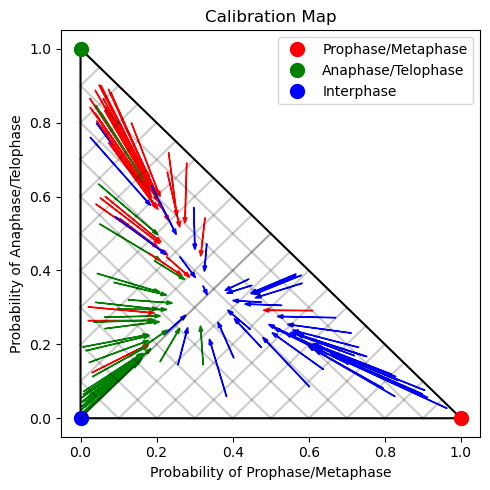

In [27]:
plt.figure(figsize=(12, 6))

plot_calibration_map(
    model.model, model.calibrated_model, 
    X_test, np.argmax(y_test, axis=1),
    title='Calibration Map',
    # sub_index=1, nrows=1, ncols=2
)

# plot_learned_calibration_map(
#     model.calibrated_model,
#     title='Learned Calibration Map',
#     sub_index=2, nrows=1, ncols=2
# )

In [8]:
model.calibrate(X_calib, y_calib, method='beta')
calibrated_pred = model.predict_proba(test_generator)

In [28]:
from sklearn.calibration import calibration_curve

def compute_multilabel_ece(probs, labels, num_bins=15):
    ece = 0.0
    num_classes = probs.shape[1]
    n_samples = probs.shape[0]
    bin_edges = np.linspace(0.0, 1.0, num_bins + 1)

    for i in range(num_classes):
        # Initialize variables for class i
        ece_class = 0.0

        # Digitize the predicted probabilities into bins
        bin_indices = np.digitize(probs[:, i], bin_edges, right=True) - 1  # Bin indices start from 0
        bin_indices = np.clip(bin_indices, 0, num_bins - 1)  # Ensure indices are within valid range

        for b in range(num_bins):
            # Find samples in bin b
            in_bin = bin_indices == b
            prop_in_bin = np.mean(in_bin)  # Proportion of samples in this bin

            if prop_in_bin > 0:
                avg_confidence_in_bin = np.mean(probs[in_bin, i])
                avg_accuracy_in_bin = np.mean(labels[in_bin, i])

                # Compute the bin's contribution to ECE
                ece_bin = np.abs(avg_confidence_in_bin - avg_accuracy_in_bin) * prop_in_bin
                ece_class += ece_bin

        ece += ece_class

    ece /= num_classes
    return ece

X_test, y_test = test_generator.get_all()
ece = compute_multilabel_ece(calibrated_pred, y_test)
print(f'Multilabel Expected Calibration Error (ECE): {ece:.4f}')

Multilabel Expected Calibration Error (ECE): 0.1602


In [29]:
from sklearn.metrics import brier_score_loss

def compute_multilabel_brier(probs, labels):
    num_classes = probs.shape[1]
    brier_scores = []

    for i in range(num_classes):
        bs = brier_score_loss(labels[:, i], probs[:, i])
        brier_scores.append(bs)

    mean_brier_score = np.mean(brier_scores)
    return mean_brier_score

brier_score = compute_multilabel_brier(calibrated_pred, y_test)
print(f'Mean Multilabel Brier Score: {brier_score:.4f}')

Mean Multilabel Brier Score: 0.0997


In [27]:
model.calibrate(X_calib, y_calib, method='isotonic')
calibrated_pred = model.predict_proba(test_generator)

ece = compute_multilabel_ece(calibrated_pred, y_test)
print(f'Multilabel Expected Calibration Error (ECE): {ece:.4f}')

brier_score = compute_multilabel_brier(calibrated_pred, y_test)
print(f'Mean Multilabel Brier Score: {brier_score:.4f}')

Multilabel Expected Calibration Error (ECE): 0.0899
Mean Multilabel Brier Score: 0.0994


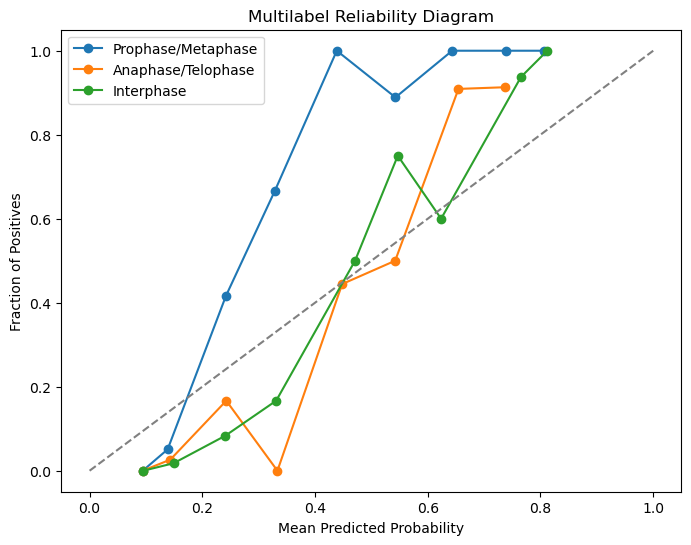

In [30]:
def plot_multilabel_reliability_diagram(probs, labels, num_bins=10):
    num_classes = probs.shape[1]
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        prob_true, prob_pred = calibration_curve(labels[:, i], probs[:, i], n_bins=num_bins)
        plt.plot(prob_pred, prob_true, marker='o', label=f'{calibration_generator.CLASS_NAMES[i]}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Multilabel Reliability Diagram')
    plt.legend()
    plt.show()

plot_multilabel_reliability_diagram(calibrated_pred, y_test)